In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import Corrfunc
from Corrfunc.io import read_lognormal_catalog
from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.theory.DD import DD
from Corrfunc.theory.xi import xi
from Corrfunc.utils import compute_amps
from Corrfunc.utils import evaluate_xi
from Corrfunc.utils import trr_analytic
from Corrfunc.utils import convert_3d_counts_to_cf
from Corrfunc.bases import spline_bases

sys.path.insert(0, '/home/aew492/research-summer2020/code')
import read_lognormal

In [2]:
#
# x, y, z = read_lognormal_catalog(n='1e-4')
# boxsize = 750.0
# nd = len(x)
# print("Number of data points:",nd)

# load in data
mock_data = read_lognormal.read('/scratch/ksf293/mocks/lognormal/cat_L750_n1e-4_z057_patchy_As2x/cat_L750_n1e-4_z057_patchy_As2x_lognormal_rlz4.bin')

boxsize, _, _, nd, data = mock_data
x, y, z, _, _, _ = data.T
xs = np.array([x, y, z]) - boxsize/2

In [3]:
nr = 2*nd
x_rand = np.random.uniform(0, boxsize, nr)
y_rand = np.random.uniform(0, boxsize, nr)
z_rand = np.random.uniform(0, boxsize, nr)
print("Number of random points:",nr)

Number of random points: 86478


### standard correlation function estimator

In [4]:
rmin = 40.0  #
rmax = 150.0  #
nbins = 22
r_edges = np.linspace(rmin, rmax, nbins+1)
r_mid = 0.5*(r_edges[1:]+r_edges[:-1])

periodic = True  #
nthreads = 2  #

In [5]:
dd_res = DD(1, nthreads, r_edges, x, y, z, boxsize=boxsize, periodic=periodic)
dr_res = DD(0, nthreads, r_edges, x, y, z, X2=x_rand, Y2=y_rand, Z2=z_rand, boxsize=boxsize, periodic=periodic)
rr_res = DD(1, nthreads, r_edges, x_rand, y_rand, z_rand, boxsize=boxsize, periodic=periodic)

In [6]:
dd = np.array([x['npairs'] for x in dd_res], dtype=float)
dr = np.array([x['npairs'] for x in dr_res], dtype=float)
rr = np.array([x['npairs'] for x in rr_res], dtype=float)
xi_ls = convert_3d_counts_to_cf(nd, nd, nr, nr, dd, dr, dr, rr)

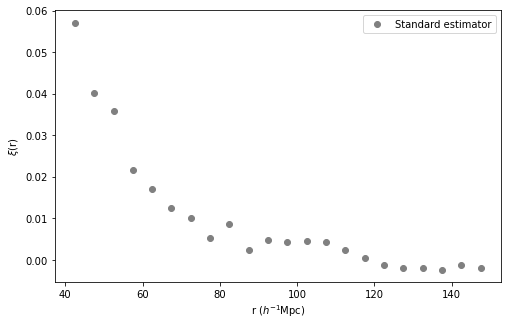

In [7]:
plt.figure(figsize=(8,5))
plt.plot(r_mid, xi_ls, marker='o', ls='None', color='grey', label='Standard estimator')
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()

### cubic spline basis

In [8]:
nmubins = 1
mumax = 1.0
r_fine = np.linspace(rmin, rmax, 2000)

In [9]:
proj_type = 'generalr'
kwargs = {'order': 3} # 3: cubic spline
projfn = '/home/aew492/research-summer2020/cubic_spline.dat'
ncomponents = int(nbins/2)
bases = spline_bases(rmin, rmax, projfn, ncomponents, ncont=1000, **kwargs)
print(bases.shape, ncomponents)

(1000, 12) 11


Text(0, 0.5, 'basis functions $f_k(r)$')

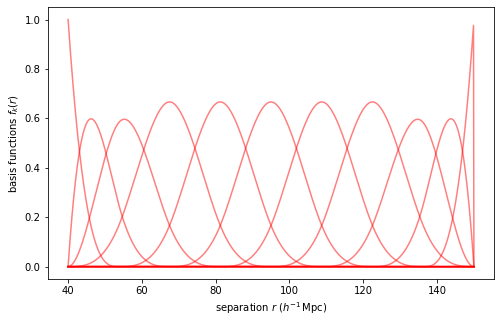

In [10]:
r = bases[:,0]
plt.figure(figsize=(8,5))
for i in range(1, len(bases[0])):
    plt.plot(r, bases[:,i], color='red', alpha=0.5)
plt.xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
plt.ylabel('basis functions $f_k(r)$')

In [11]:
dd_res_spline, dd_spline, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z,
                                    boxsize=boxsize, periodic=periodic, proj_type=proj_type,
                                    ncomponents=ncomponents, projfn=projfn)

In [12]:
# analytically computing the random term
volume = boxsize**3
rr_ana_spline, trr_ana_spline = trr_analytic(rmin, rmax, nd, volume, ncomponents, proj_type, projfn=projfn)

numerator = dd_spline - rr_ana_spline
amps_ana_spline = np.linalg.solve(trr_ana_spline, numerator)

xi_ana_spline = evaluate_xi(amps_ana_spline, r_fine, proj_type, projfn=projfn)

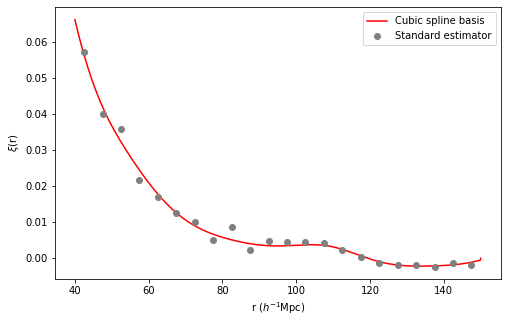

In [13]:
plt.figure(figsize=(8,5))
plt.plot(r_fine, xi_ana_spline, color='red', label='Cubic spline basis')
plt.plot(r_mid, xi_ls, marker='o', ls='None', color='grey', label='Standard estimator')
plt.xlabel(r'r ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi$(r)')
plt.legend()